In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.distributions import Normal, Gamma
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
from skimage import data
from skimage.transform import rescale

/home/alexey/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


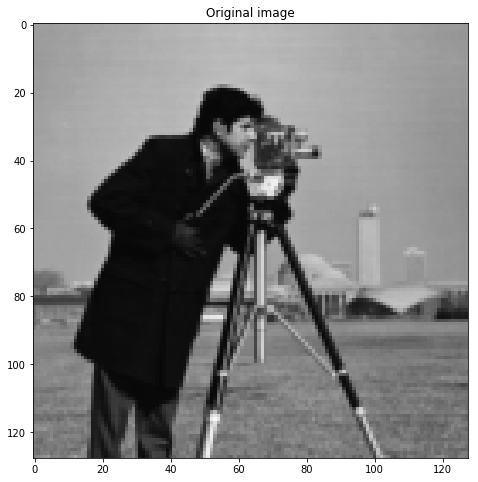

In [4]:
# load image
y0 = data.camera()
y0 = y0.astype(np.float64)

y0 = rescale(y0, 0.25)

M, N = y0.shape

plt.figure(figsize=(8,8))
plt.imshow(y0, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Original image')
plt.show()

In [5]:
from numpy.fft import fft2, ifft2
from scipy.signal import convolve2d

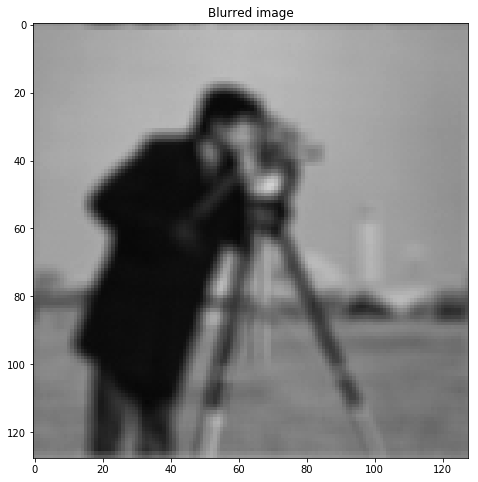

In [6]:
lh = 5

kernel = np.ones((lh, lh))
kernel = kernel/np.sum(kernel)

h = np.zeros(y0.shape)
h[0:lh, 0:lh] = kernel
h = h/h.sum()
h = np.roll(h,-int((lh-1)/2.), axis=1) # circular shift
h = np.roll(h,-int((lh-1)/2.), axis=0) # circular shift

#y = np.real(ifft2(fft2(h)*fft2(y0))) + 0.5*np.random.randn(M,N)
y = convolve2d(y0, kernel, mode='same', boundary='wrap') + 0.5*np.random.randn(M,N)


plt.figure(figsize=(8,8))
plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Blurred image')
plt.show()

In [7]:
def gradient_x(img):
    # Pad input to keep output size consistent
    img = F.pad(img, (0, 1, 0, 0), mode="replicate") # (pad_left, pad_right, pad_top, pad_bottom)
    gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
    return gx

def gradient_y(img):
    # Pad input to keep output size consistent
    img = F.pad(img, (0, 0, 0, 1), mode="replicate") # (pad_left, pad_right, pad_top, pad_bottom)
    gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
    return gy

def image_gradients(img):
    shape = img.shape
    dx = gradient_x(img.view(1,1,*shape)).squeeze()
    dy = gradient_y(img.view(1,1,*shape)).squeeze()
    return dx, dy

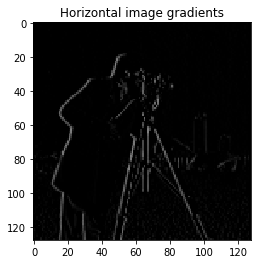

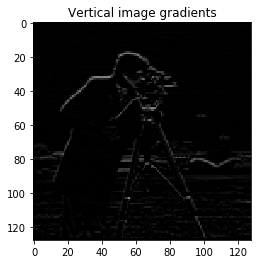

In [8]:
image = torch.from_numpy(y0)

dx, dy = image_gradients(image)

plt.imshow(dx.numpy(), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Horizontal image gradients')
plt.show()

plt.imshow(dy.numpy(), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Vertical image gradients')
plt.show()

In [9]:
def pad_circular(x, pad):
    """
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[0:pad]], dim=0)
    x = torch.cat([x, x[:, 0:pad]], dim=1)
    x = torch.cat([x[-2 * pad:-pad], x], dim=0)
    x = torch.cat([x[:, -2 * pad:-pad], x], dim=1)
    return x

In [10]:
import torch.nn as nn

print(kernel.shape)

convolution2d = nn.Conv2d(1, 1, kernel.shape)
convolution2d.weight = nn.Parameter(torch.from_numpy(kernel).view(1,1,lh,lh))
convolution2d.weight.requires_grad = False
convolution2d.bias = nn.Parameter(torch.zeros(1,).double())
convolution2d.bias.requires_grad = False

(5, 5)


In [11]:
def H(x):
    p = lh // 2
    x_padded = pad_circular(x, pad=p)
    shape = x_padded.shape
    x_cov = torch.squeeze(convolution2d(x_padded.view(1,1,*shape)))
    return x_cov

In [12]:
print(convolution2d.weight)
print(convolution2d.bias)

Parameter containing:
tensor([[[[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]]]], dtype=torch.float64)
Parameter containing:
tensor([0.], dtype=torch.float64)


1.7028108530941953e-23


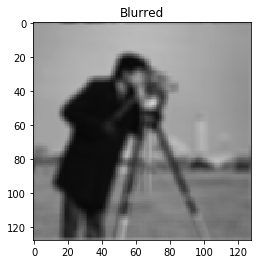

In [13]:
image = torch.from_numpy(y0)

image_blurred = H(image).numpy()
image_blurred_np = np.real(ifft2(fft2(h)*fft2(y0)))

print(np.sum((image_blurred - image_blurred_np)**2))

plt.imshow(image_blurred, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Blurred')
plt.show()

In [14]:
def D(img):
    dx, dy = image_gradients(img)
    return torch.cat([dx.unsqueeze(2), dy.unsqueeze(2)], dim=2)

In [15]:
safe_softplus = lambda x: F.softplus(x)

real2pos = lambda x: safe_softplus(x)

In [16]:
print(safe_softplus(torch.Tensor(1000*np.ones((2,3)))))

tensor([[1000., 1000., 1000.],
        [1000., 1000., 1000.]])


In [17]:
a0 = 0.1
b0 = 50.
sigma = 1.

In [19]:
Y = torch.from_numpy(y.copy()).double()

In [358]:
shape = (N,M,2)

a_var = Variable(1 + torch.rand(*shape, dtype=torch.float64), requires_grad=True)
b_var = Variable(1 + torch.rand(*shape, dtype=torch.float64), requires_grad=True)
sigma_var = Variable(torch.rand(N,M, dtype=torch.float64), requires_grad=True)
#sigma_posterior = Variable(real2pos(sigma_var), requires_grad=True)
mu_posterior = Variable(torch.from_numpy(y.copy()).double(), requires_grad=True)


def compute_neg_elbo():

    n_samples = 3
    
    x_posterior = Normal(mu_posterior, real2pos(sigma_var))
    lmbda_posterior = Gamma(real2pos(a_var), real2pos(b_var))

    x_samples = x_posterior.rsample([n_samples])
    lmbda_samples = lmbda_posterior.rsample([n_samples])

    unnormalized_posterior = 0.

    for i in range(n_samples):
                
        a = a0 + 0.5 - 1
        b = b0 + 0.5*(D(x_samples[i]))**2

        log_term = a * torch.sum(torch.log(lmbda_samples[i]))
        linear_term = torch.sum(b * lmbda_samples[i])
        lmbda_unnorm_post = log_term - linear_term

        residual = H(x_samples[i]) - Y
        unnormalized_posterior += -0.5/sigma*torch.norm(residual)**2 + lmbda_unnorm_post

    q_entropy = torch.sum(x_posterior.entropy()) + torch.sum(lmbda_posterior.entropy()) 
    neg_elbo = -(1./n_samples*unnormalized_posterior + q_entropy)
    
    return neg_elbo


In [214]:
x = Variable(torch.from_numpy(y.copy()).double(), requires_grad=True)

def l2_loss():
    residual = H(x) - Y
    return torch.mean(residual**2) + 0.0*torch.norm(x)**2 

In [359]:
params = [a_var, b_var, mu_posterior, sigma_var]

In [360]:
optimizer = torch.optim.Adam(params, lr=0.1)

max_iter = 20000
for k in range(max_iter):

    loss = compute_neg_elbo()    
    #loss = l2_loss()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if k % 500 == 0:
        print("%5d, -elbo: %f" % (k, loss.detach().numpy()))
        #print(torch.norm(sigma_posterior))
    

    0, -elbo: 2833945.350124
  500, -elbo: 120265.216681
 1000, -elbo: 91067.412810
 1500, -elbo: 76818.535934
 2000, -elbo: 70267.617619
 2500, -elbo: 65232.717684
 3000, -elbo: 60800.829452
 3500, -elbo: 57092.589118
 4000, -elbo: 53606.500981
 4500, -elbo: 52312.253828
 5000, -elbo: 51212.611950
 5500, -elbo: 48927.427260
 6000, -elbo: 47203.750445
 6500, -elbo: 47408.096970
 7000, -elbo: 45373.681401
 7500, -elbo: 44799.591219
 8000, -elbo: 43655.124457
 8500, -elbo: 43430.434877
 9000, -elbo: 42276.083056
 9500, -elbo: 42546.006270
10000, -elbo: 41334.298702
10500, -elbo: 41106.658096
11000, -elbo: 41041.139815
11500, -elbo: 40546.984784
12000, -elbo: 40136.483085
12500, -elbo: 40185.086226
13000, -elbo: 39711.334997
13500, -elbo: 39519.064988
14000, -elbo: 39391.736379
14500, -elbo: 38994.724442
15000, -elbo: 39240.520878
15500, -elbo: 38816.659738
16000, -elbo: 38723.104576
16500, -elbo: 38743.616530
17000, -elbo: 38242.978306
17500, -elbo: 38397.922094
18000, -elbo: 38784.74756

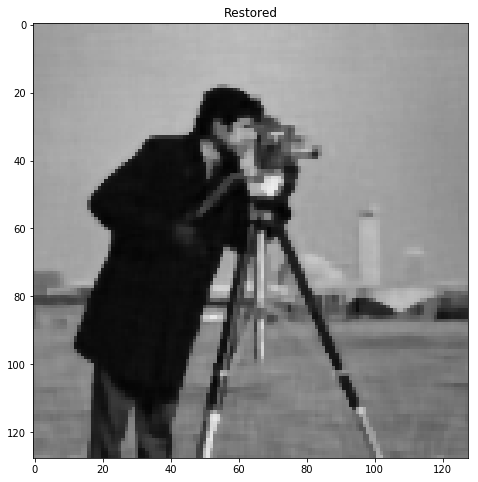

In [363]:
y_recovered = mu_posterior.detach().numpy()

plt.figure(figsize=(8,8))
plt.imshow(y_recovered, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored')
plt.show()

In [362]:
mse = np.linalg.norm(y_recovered - y0,'fro')**2 /(M*N)

print("MSE: %0.2f" % (mse))

MSE: 35.68
